# Downloading Data

In [ ]:
!mkdir ~/.kaggle
!echo "{\"username\":\"rohit369\",\"key\":\"7569c483b88476793f6202dffae24b9d\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

!kaggle datasets download -d rohit369/human-background-segmentation

!mkdir ./data
!unzip human-background-segmentation.zip -d ./data/
!rm human-background-segmentation.zip

### Imports

In [ ]:
import torch
from torch import nn, optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import join
import random


### Visualization

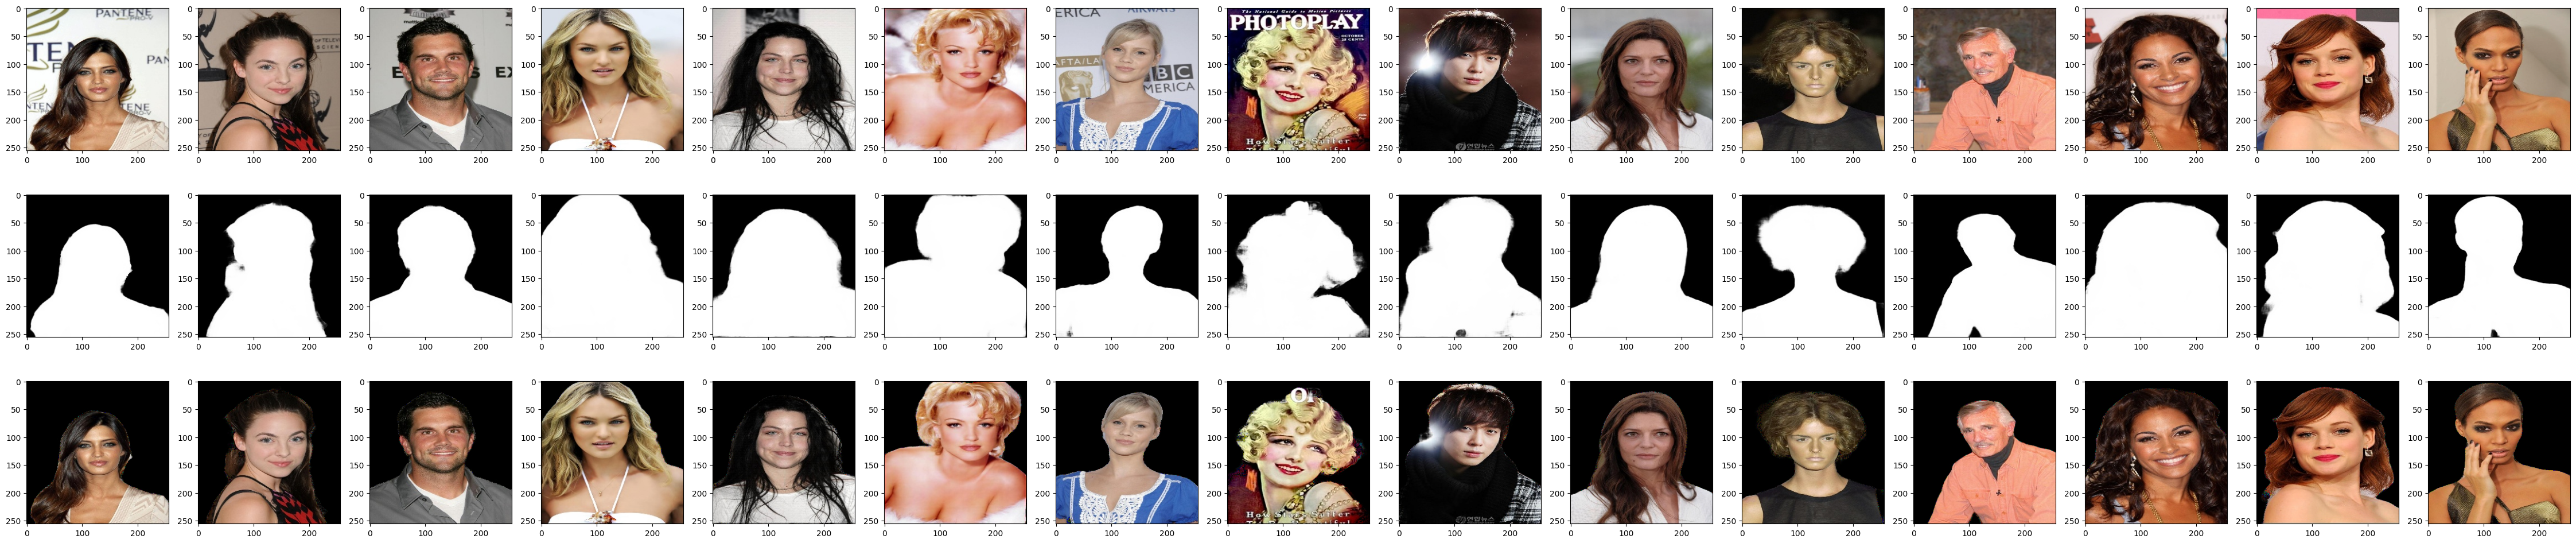

In [ ]:
x_base = 'data/val/img/1803151818/img_00000000/'
y_base = x_base.replace('img', 'mask')

tokens = os.listdir(x_base)
num = min(15, len(tokens))

fig, axes = plt.subplots(3, num, figsize=(num*3, 10))

for i in range(num):
    idx = random.randint(0, len(tokens))
    img = cv2.cvtColor(cv2.imread(x_base + tokens[idx]), cv2.COLOR_BGR2RGB)
    
    msk = cv2.cvtColor(cv2.imread(y_base + tokens[idx]), cv2.COLOR_BGR2RGB)

    res = cv2.bitwise_and(img, msk)

    axes[0, i].imshow(img)
    axes[1, i].imshow(msk)
    axes[2, i].imshow(res)


plt.tight_layout()
plt.show()


### Dataset

In [ ]:
class SegDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.images = []
        self.transform = transform

        for sub1 in listdir(join(base_dir, 'img')):
            for sub2 in listdir(join(base_dir, 'img', sub1)):
                for fn in listdir(join(base_dir, 'img', sub1, sub2)):
                    self.images.append(join(base_dir, 'img', sub1, sub2, fn))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.images[index].replace('img', 'mask'))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = (image - image.min()) / (image.max() - image.min())
        mask = (mask - mask.min()) / (mask.max() - mask.min())

        return image, mask


### Utils

In [ ]:
def load_checkpoint(checkpoint, model):
    print('=> Loading Checkpoint', end='\r')
    model.load_state_dict(checkpoint['state_dict'])
    print('=> Checkpoint Loaded')

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    print('=> Saving checkpoint', end='\r')
    torch.save(state, filename)
    print('=> Checkpoint Saved')

def get_loaders(
        train_dir,
        val_dir,
        batch_size,
        train_transform,
        val_transform,
        num_workers=2,
        pin_memory=True
):
    train_ds = SegDataset(
        base_dir=train_dir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
        drop_last=True,
    )

    val_ds = SegDataset(
        base_dir=val_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
        drop_last=True,
    )

    return train_loader, val_loader

def evaluate_model(loader, model, loss_fn, device):
    n_correct = 0
    n_pixels = 0
    dice_score = 0

    losses = []

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.float().to(device)
            y = y.float().unsqueeze(1).to(device)

            # preds = torch.sigmoid(model(x))
            with torch.no_grad():
                preds = torch.sigmoid(model(x)['out']) # if the model is deeplabv3
                losses.append(loss_fn(preds, y).item())

            preds = (preds > .5).float()

            n_correct += (preds == y).sum()
            n_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8)
    
    accuracy = (n_correct/n_pixels).item()
    dice_score = (dice_score/len(loader)).item()
    loss = sum(losses)/len(losses)

    print(f'Accuracy: {accuracy}, Dice-Score: {dice_score}, Loss: {loss}')
    model.train()

    return accuracy, dice_score, loss


### Train

In [ ]:
# epochs 1 + 25.
LR = 1e-4
BATCH_SIZE = 150
NUM_WORKERS = 2 # >> nproc or lscpu
PIN_MEMORY = True
LOAD_MODEL = True
NUM_EPOCHS = 25

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMAGE_DIR = './data/train/'
VAL_IMAGE_DIR = './data/val/'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    accuracy = []
    losses = []

    for data, targets in loop:
        data = data.float().to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            preds = model(data)['out']
            loss = loss_fn(preds, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # calculate accuracy
        preds = (preds > .5).float()
        n_correct = (preds == targets).sum()
        n_pixels = torch.numel(preds)

        acc = n_correct/n_pixels

        # update tqdm loop
        loop.set_postfix(loss=loss.item(), acc=acc.item())

        accuracy.append(acc.item())
        losses.append(loss.item())

    return sum(accuracy)/len(accuracy), sum(losses)/len(losses)

def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.1),
        A.Rotate(limit=45, p=.15),
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.2),
        A.RandomFog(fog_coef_lower=0.5, p=.4),
        A.RandomRain(p=.1),
        A.Sharpen(p=.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # loading the pretrained deeplabv3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DeepLabV3_ResNet50_Weights.DEFAULT')

    # adding a layer at the end
    model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))

    model.aux_classifier = None

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)
    # scheduler = lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max = NUM_EPOCHS, # Maximum number of iterations.
    #     eta_min = 1e-5, # Minimum learning rate.
    #     verbose=True
    # )

    train_loader, val_loader = get_loaders(
        TRAIN_IMAGE_DIR,
        VAL_IMAGE_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load('checkpoint.pth.tar'), model)
    
    if torch.cuda.is_available():
        model.to('cuda')

    model.train()
    
    scaler = torch.cuda.amp.GradScaler()

    history = {
        'train': [],
        'val': []
    }

    for epoch in range(NUM_EPOCHS):
        t_acc, t_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        history['train'].append([t_acc, t_loss])

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)

        print('Epoch:', epoch, end=', ')
        v_acc, v_dice_score, v_loss = evaluate_model(val_loader, model, loss_fn, DEVICE)
        history['val'].append([v_acc, v_dice_score, v_loss])

        # if epoch != (NUM_EPOCHS-1):
            # scheduler.step()
    
    return history

history = main()
history['val'] = np.array(history['val'])
history['train'] = np.array(history['train'])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


=> Checkpoint Loaded


100%|██████████| 160/160 [01:23<00:00,  1.92it/s, acc=0.871, loss=0.025]


=> Checkpoint Saved
Epoch: 0, Accuracy: 0.8394988775253296, Dice-Score: 0.9896402955055237, Loss: 0.46058796842892963


100%|██████████| 160/160 [01:23<00:00,  1.92it/s, acc=0.88, loss=0.0247]


=> Checkpoint Saved
Epoch: 1, Accuracy: 0.8395133018493652, Dice-Score: 0.9897887706756592, Loss: 0.46049027814381366


 27%|██▋       | 43/160 [00:24<01:06,  1.77it/s, acc=0.874, loss=0.0259]


KeyboardInterrupt: ignored

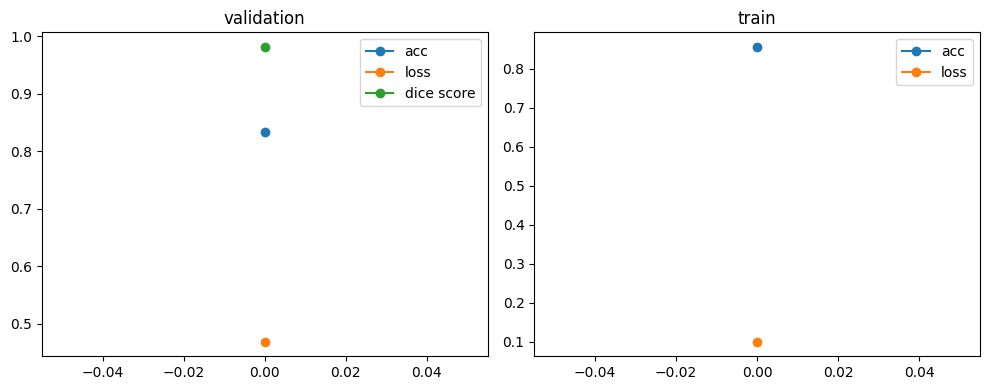

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.title('validation')
plt.plot(history['val'][:, 0], '-o', label='acc')
plt.plot(history['val'][:, 2], '-o', label='loss')
plt.plot(history['val'][:, 1], '-o', label='dice score')

plt.legend()

plt.subplot(122)
plt.title('train')
plt.plot(history['train'][:, 0], '-o', label='acc')
plt.plot(history['train'][:, 1], '-o', label='loss')
plt.legend()

plt.tight_layout()
plt.show()


### Testing model performance/accuracy

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DeepLabV3_ResNet50_Weights.DEFAULT')
model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))
model.aux_classifier = None

load_checkpoint(torch.load('checkpoint.pth.tar'), model)

model.eval()

model.to('cuda')

aug = A.Compose([
    A.CLAHE(clip_limit=10, tile_grid_size=(8, 8), p=.3),
    A.Rotate(limit=45, border_mode=cv2.BORDER_CONSTANT, value=0, p=.1),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.RandomFog(fog_coef_lower=0.5, p=.3),
    A.RandomRain(p=.2),
    A.Sharpen(p=.2),
])


val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    aug,
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_ds = SegDataset(
    base_dir='./data/val/',
    transform=val_transform
)

val_loader = DataLoader(
    val_ds,
    batch_size=10,
    num_workers=2,
    pin_memory=False,
    shuffle=False,
    drop_last=True
)

preds = []
X = []
Y = []

for x, y in tqdm(val_loader):
    x = x.float().to('cuda')
    y = y.float().unsqueeze(1).to('cuda')
    with torch.no_grad():
        preds.append(model(x)['out'].to('cpu'))
        X.append(x.to('cpu'))
        Y.append(y.to('cpu').squeeze())


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


=> Checkpoint Loaded


100%|██████████| 1038/1038 [00:39<00:00, 26.50it/s]


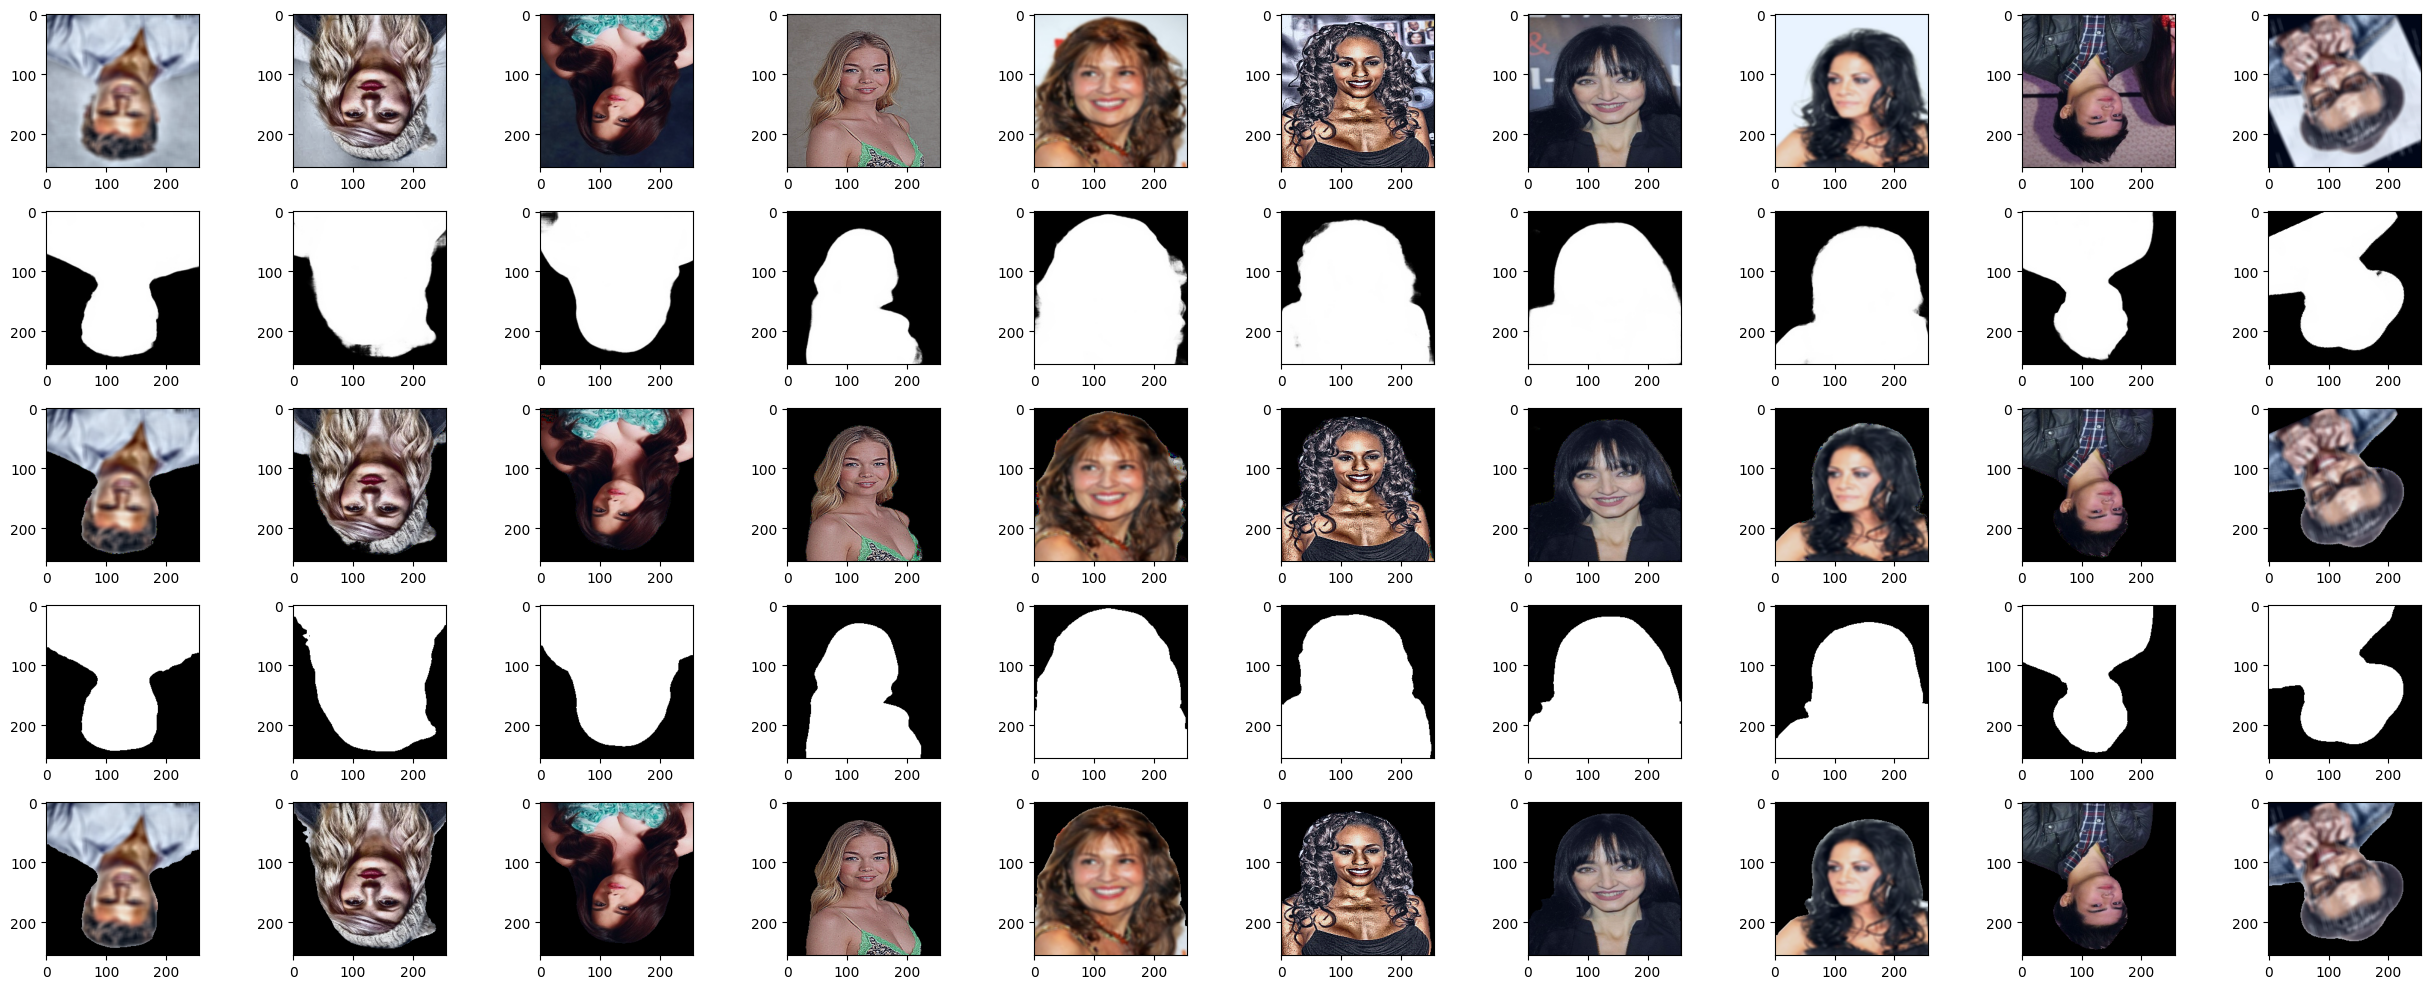

In [ ]:
batch_idx = random.randint(0, len(X)-1)

# batch_idx = 9 # max 15

fig, axes = plt.subplots(5, 10, figsize=(25, 10))

Img = X[batch_idx]
Mask = Y[batch_idx]
Pred = preds[batch_idx]

for idx, (img, mask, pred) in enumerate(zip(Img, Mask, Pred)):
    img = (np.transpose(img.numpy(), (1, 2, 0)) * 255).astype('uint8')
    mask = (cv2.cvtColor(mask.numpy(), cv2.COLOR_GRAY2RGB) * 255).astype('uint8')
    pred = (torch.sigmoid(pred.detach()) > .5).float().numpy().squeeze()
    pred = (cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB) * 255).astype('uint8')

    truth_res = cv2.bitwise_and(img, mask)
    pred_res = cv2.bitwise_and(img, pred)

    axes[0, idx].imshow(img)
    axes[1, idx].imshow(mask)
    axes[2, idx].imshow(truth_res)
    axes[3, idx].imshow(pred)
    axes[4, idx].imshow(pred_res)

plt.tight_layout()
plt.show()


### Saving the model

In [ ]:
# !ls -Flash

# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights='DeepLabV3_ResNet50_Weights.DEFAULT')
# model.classifier.append(torch.nn.Conv2d(in_channels=21, out_channels=1, kernel_size=(1, 1), stride=1))
# model.aux_classifier = None

# load_checkpoint(torch.load('checkpoint.pth.tar'), model)

# torch.save(model, 'deeplabv3_bg_seg_model_v2.pth')
# !zip deeplabv3_bg_seg_model_v2.pth.zip deeplabv3_bg_seg_model_v2.pth


total 747M
4.0K drwxr-xr-x 1 root root 4.0K May  7 14:10 ./
4.0K drwxr-xr-x 1 root root 4.0K May  7 12:21 ../
455M -rw-r--r-- 1 root root 455M May  7 14:03 checkpoint.pth.tar
4.0K drwxr-xr-x 4 root root 4.0K May  3 13:30 .config/
4.0K drwxr-xr-x 4 root root 4.0K May  7 12:34 data/
152M -rw-r--r-- 1 root root 152M May  7 14:10 deeplabv3_bg_seg_model_v2.pth
141M -rw-r--r-- 1 root root 141M May  7 14:10 deeplabv3_bg_seg_model_v2.pth.zip
4.0K drwxr-xr-x 2 root root 4.0K May  7 14:09 .ipynb_checkpoints/
4.0K drwxr-xr-x 1 root root 4.0K May  3 13:31 sample_data/


In [31]:
!cp ./deeplabv3_bg_seg_model_v2.pth.zip ./drive/MyDrive/Datasets/Human\ Segmentation/